### LDA Attempt # 2

In this notebook, I use LDA to find topics, and then I perform clustering

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import pickle

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
with open("all_lines","rb") as pickle_in:
    all_lines = pickle.load(pickle_in)

In [3]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(all_lines))

print(data_words[:1])

[['space', 'it', 'seems', 'to', 'go', 'on', 'and', 'on', 'forever', 'but', 'then', 'you', 'get', 'to', 'the', 'end', 'and', 'the', 'gorilla', 'starts', 'throwing', 'barrels', 'at', 'you', 'and', 'that', 'how', 'you', 'play', 'the', 'game', 'michelle', 'baby', 'where', 'you', 'going', 'hate', 'my', 'life', 'hate', 'my', 'life', 'hate', 'my', 'life', 'hello', 'pizza', 'delivery', 'for', 'uh', 'here', 'to', 'another', 'lousy', 'millennium']]


In [4]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['space', 'it', 'seems', 'to', 'go', 'on', 'and', 'on', 'forever', 'but', 'then', 'you', 'get', 'to', 'the', 'end', 'and', 'the', 'gorilla', 'starts', 'throwing', 'barrels', 'at', 'you', 'and', 'that', 'how', 'you', 'play', 'the', 'game', 'michelle', 'baby', 'where', 'you', 'going', 'hate', 'my', 'life', 'hate', 'my', 'life', 'hate', 'my', 'life', 'hello', 'pizza_delivery', 'for', 'uh', 'here', 'to', 'another', 'lousy', 'millennium']


In [5]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/isaackim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [30]:
stop_words2 = stop_words.extend(['fry','bender','leela','amy','hermes','professor,','zoidberg'])

In [31]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['space', 'seem', 'go', 'forever', 'get', 'end', 'gorilla', 'start', 'throw', 'barrel', 'play', 'game', 'michelle', 'baby', 'go', 'hate', 'life', 'hate', 'life', 'hate', 'life', 'pizza_delivery', 'lousy', 'millennium']]


In [32]:
type(id2word)

gensim.corpora.dictionary.Dictionary

In [41]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=2, no_above=.1)
# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 3), (7, 3), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]]


In [42]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('baby', 1),
  ('barrel', 1),
  ('end', 1),
  ('forever', 1),
  ('game', 1),
  ('gorilla', 1),
  ('hate', 3),
  ('life', 3),
  ('lousy', 1),
  ('michelle', 1),
  ('millennium', 1),
  ('pizza_delivery', 1),
  ('play', 1),
  ('seem', 1),
  ('space', 1),
  ('start', 1),
  ('throw', 1)]]

In [51]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [52]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.047*"kif" + 0.030*"captain" + 0.024*"woman" + 0.019*"first" + '
  '0.012*"remember" + 0.010*"world" + 0.009*"together" + 0.008*"wong" + '
  '0.008*"fight" + 0.008*"fly"'),
 (1,
  '0.019*"ship" + 0.018*"work" + 0.017*"robot" + 0.017*"new" + 0.016*"earth" + '
  '0.011*"nothing" + 0.009*"keep" + 0.009*"human" + 0.009*"space" + '
  '0.008*"fire"'),
 (2,
  '0.030*"professor" + 0.020*"must" + 0.019*"kill" + 0.017*"planet" + '
  '0.014*"name" + 0.013*"boy" + 0.012*"man" + 0.011*"turn" + 0.011*"word" + '
  '0.009*"hell"'),
 (3,
  '0.027*"sweet" + 0.016*"child" + 0.013*"poor" + 0.012*"point" + '
  '0.012*"prepare" + 0.011*"father" + 0.011*"nibbler" + 0.009*"hot" + '
  '0.009*"stick" + 0.009*"hurt"'),
 (4,
  '0.019*"love" + 0.017*"sir" + 0.016*"want" + 0.016*"never" + 0.015*"may" + '
  '0.013*"way" + 0.012*"life" + 0.012*"stop" + 0.012*"mean" + 0.012*"really"'),
 (5,
  '0.016*"give" + 0.015*"man" + 0.015*"thank" + 0.014*"call" + 0.012*"day" + '
  '0.012*"everyone" + 0.011*"year" + 0.01

In [53]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -8.034816617027905

Coherence Score:  0.30982921518126244


### Looking for the optimum number of topics using coherence scores

In [31]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [32]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

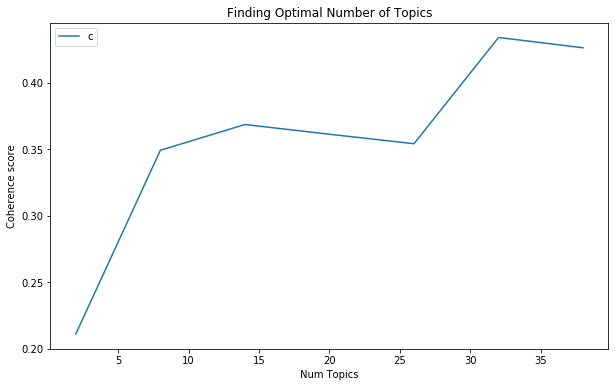

In [33]:
# Show graph
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6)
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.title("Finding Optimal Number of Topics")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [38]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, texts=data_lemmatized, start=8, limit=14, step=1)

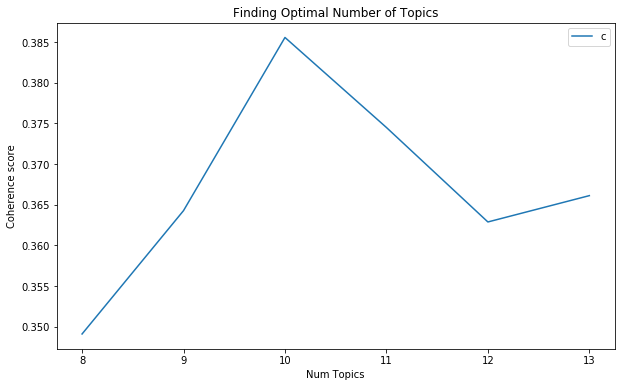

In [39]:
# Show graph
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6)
limit=14; start=8; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.title("Finding Optimal Number of Topics")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [54]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/isaackim/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.302584 -0.018660       1        1  28.938192
5      0.161261  0.138450       2        1  21.990057
1     -0.047683 -0.350851       3        1  18.383308
2     -0.088429  0.090519       4        1  13.405289
0     -0.203266  0.100418       5        1  10.409435
3     -0.124467  0.040124       6        1   6.873720, topic_info=     Category        Freq       Term       Total  loglift  logprob
1998  Default  257.000000        kif  257.000000  30.0000  30.0000
285   Default  212.000000  professor  212.000000  29.0000  29.0000
447   Default  166.000000    captain  166.000000  28.0000  28.0000
337   Default  288.000000       love  288.000000  27.0000  27.0000
576   Default  181.000000       ship  181.000000  26.0000  26.0000
158   Default  132.000000      woman  132.000000  25.0000  25.0000
329   Default  176.000000       work  176.000000  24.0000  24.0000
288   Default  140.000000       must  140.000000  23.0000  23.0000
78    Default  167.000000      robot  167.000000  22.0000  22.0000
39    Default  185.000000       give  185.000000  21.0000  21.0000
50    Default  227.000000        may  227.000000  20.0000  20.0000
74    Default  163.000000        new  163.000000  19.0000  19.0000
961   Default  135.000000       kill  135.000000  18.0000  18.0000
21    Default  242.000000      never  242.000000  17.0000  17.0000
157   Default  253.000000       want  253.000000  16.0000  16.0000
1394  Default   98.000000      sweet   98.000000  15.0000  15.0000
339   Default  175.000000      thank  175.000000  14.0000  14.0000
244   Default  284.000000        sir  284.000000  13.0000  13.0000
28    Default  152.000000      earth  152.000000  12.0000  12.0000
67    Default  164.000000       call  164.000000  11.0000  11.0000
206   Default  121.000000     planet  121.000000  10.0000  10.0000
125   Default  107.000000      first  107.000000   9.0000   9.0000
130   Default  284.000000        man  284.000000   8.0000   8.0000
7     Default  189.000000       life  189.000000   7.0000   7.0000
109   Default  184.000000       stop  184.000000   6.0000   6.0000
89    Default  177.000000     really  177.000000   5.0000   5.0000
102   Default  143.000000        day  143.000000   4.0000   4.0000
277   Default  210.000000        way  210.000000   3.0000   3.0000
410   Default  180.000000       mean  180.000000   2.0000   2.0000
123   Default  139.000000   everyone  139.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
507    Topic6   46.950718       poor   47.693516   2.6618  -4.3434
1040   Topic6   42.571491      point   43.321239   2.6600  -4.4413
1658   Topic6   41.684521    prepare   42.440784   2.6595  -4.4624
1911   Topic6   39.056980     father   39.803989   2.6585  -4.5275
741    Topic6   38.294159    nibbler   39.033096   2.6584  -4.5472
437    Topic6   34.116367        hot   34.858295   2.6560  -4.6627
1136   Topic6   33.245941      stick   33.988056   2.6554  -4.6886
627    Topic6   32.121273       hurt   32.866364   2.6545  -4.7230
867    Topic6   31.960857       send   32.705971   2.6544  -4.7280
1433   Topic6   31.951536     battle   32.711414   2.6540  -4.7283
2050   Topic6   30.910538   tomorrow   31.654934   2.6537  -4.7614
2098   Topic6   30.636242  good_news   31.385710   2.6533  -4.7703
1334   Topic6   28.129494   computer   28.896435   2.6506  -4.8557
2285   Topic6   26.557100   complete   27.308874   2.6496  -4.9132
435    Topic6   25.838127        dog   26.582069   2.6491  -4.9406
412    Topic6   26.012739      enjoy   26.761724   2.6491  -4.9339
1187   Topic6   26.012268    private   26.779203   2.6484  -4.9339
433    Topic6   25.139788     change   25.881115   2.6484  -4.9680
503    Topic6   23.955763       card   24.698923   2.6469  -5.0163
626    Topic6   23.821953     honour   24.564791   2.6468  -5.0219
434    Topic6   23.625006      count   24

In [40]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.4349,"kill, great, put, nice, anything, end, mind, p...","[space, seem, go, forever, get, end, gorilla, ..."
1,1,5.0,0.3595,"kif, man, love, want, never, little, right, ca...","[future, parent, girlfriend, never, see, yahoo..."
2,2,5.0,0.3361,"kif, man, love, want, never, little, right, ca...","[sort, eye, cool, alien, race, take, earth, wa..."
3,3,5.0,0.3998,"kif, man, love, want, never, little, right, ca...","[year, know, guess, actually, glad, nothing, l..."
4,4,5.0,0.2566,"kif, man, love, want, never, little, right, ca...","[delivery_boy, anything, else, refuse, fine, d..."
5,5,5.0,0.3474,"kif, man, love, want, never, little, right, ca...","[see, thousand_year, owe, whoa, cool, cross, t..."
6,6,5.0,0.3683,"kif, man, love, want, never, little, right, ca...","[place, collect, call, help, happen, would, ro..."
7,7,5.0,0.3764,"kif, man, love, want, never, little, right, ca...","[wait, friend, ever, oh, cyclop, look, look, s..."
8,8,5.0,0.2677,"kif, man, love, want, never, little, right, ca...","[unbelievable, head, day, stop, boy, bad, pres..."
9,9,5.0,0.3561,"kif, man, love, want, never, little, right, ca...","[mon, make, decision, life, separate, people, ..."


In [41]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.4483,"woman, always, world, poor, fight, matter, fly, job, low, doctor","[comfy, batter, batter, batter, anymore, batter, batter, batter, batter, batter, batter, batter,..."
1,1.0,0.3023,"stay, father, wife, wave, deep, waste, doom, money, air, join","[weak, know, place, great, artificial, gravity, air, gopher, may, well, stay, earth, come, see, ..."
2,2.0,0.3810,"stop, mean, happen, space, turn, word, last, move, blow, worry","[ask, oracle, think, go, pull, major, theft, thursday, familiar, particular, location, word, mal..."
3,3.0,0.3219,"ship, sweet, stand, kid, hooray, fat, quiet, catch, mix, law","[old, listen, kid, get, lawn, get, talk, hump, syndrome, stick, old, people, horrific, come, ste..."
4,4.0,0.4349,"kill, great, put, nice, anything, end, mind, perhaps, understand, baby","[space, seem, go, forever, get, end, gorilla, start, throw, barrel, play, game, michelle, baby, ..."
5,5.0,0.7207,"kif, man, love, want, never, little, right, captain, way, may","[sound, could, little, oil, crud, cent, short, old, bank, maybe, account, still, open, open, acc..."
6,6.0,0.3780,"professor, new, year, first, leave, name, ask, parent, bring, start","[old, neighbourhood, man, bring, back, lot, memory, bring, girlfriend, first, date, god, go, eve..."
7,7.0,0.2736,"talk, someone, head, hell, mon, run, fine, ready, heart, fun","[outlaw, slurm, pay, attention, sir, grandpa, make, crazy, story, wish, slurm, mackenzie, enjoy,..."
8,8.0,0.3377,"friend, eat, part, true, anyone, free, business, point, party, cute","[know, big, vinnie, say, give, kiss, death, still, think, gay, little, ok, happen, feel, weird, ..."
9,9.0,0.3760,"sir, need, would, earth, bad, keep, place, fire, happy, watch","[get, lot, kansa, check, new, security, guard, get, badge, flashlight, order, mustache, restart,..."
